In [29]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [30]:
tf.config.set_visible_devices([], 'GPU')

In [31]:
with open('data_configs/data_500.json', 'r') as file:
    config = json.load(file)

In [159]:
# import data
xt = np.load('x_train.npy')
xt /= np.max(xt, axis=1, keepdims=True)
xv = np.load('x_val.npy')
xv /= np.max(xv, axis=1, keepdims=True)
xtest = np.load('x_test.npy')#[::3]
xtest /= np.max(xtest, axis=1, keepdims=True)
xp = xtest[::9]

yt = np.load('y_train.npy') # class
# yv = np.load('y_val.npy')
# ytest = np.load('y_test.npy')
# yp = ytest[::9]

# classes = np.unique(ytest).size
# yt = tf.one_hot(yt, classes)
# yv = tf.one_hot(yv, classes)
# ytest = tf.one_hot(ytest, classes)

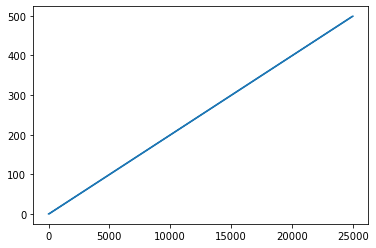

In [158]:
plt.plot(yt)

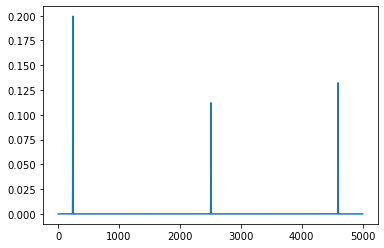

In [120]:
plt.plot(xtest[202])

In [33]:
cnn2 = tf.keras.models.load_model('model_weights/cnn2-4.h5')
cnn3 = tf.keras.models.load_model('model_weights/cnn3-3.h5')
cnn6 = tf.keras.models.load_model('model_weights/cnn6-0.h5')
vgg = tf.keras.models.load_model('model_weights/vgg-3.h5')
resnet = tf.keras.models.load_model('model_weights/resnet-2.h5')
inc3 = tf.keras.models.load_model('model_weights/inc3-0.h5')
inc6 = tf.keras.models.load_model('model_weights/inc6-0.h5')

In [34]:
model_list = [cnn2, cnn3, cnn6, vgg, resnet, inc3, inc6]
_ = [model.evaluate(xtest, ytest, batch_size=16, verbose=2) for model in model_list]

282/282 - 4s - loss: 0.0053 - accuracy: 0.9980 - 4s/epoch - 15ms/step
282/282 - 9s - loss: 0.0031 - accuracy: 0.9989 - 9s/epoch - 33ms/step
282/282 - 29s - loss: 0.0021 - accuracy: 0.9996 - 29s/epoch - 103ms/step
282/282 - 5s - loss: 0.0035 - accuracy: 0.9987 - 5s/epoch - 17ms/step
282/282 - 67s - loss: 0.0020 - accuracy: 0.9998 - 67s/epoch - 236ms/step
282/282 - 16s - loss: 4.0455e-04 - accuracy: 1.0000 - 16s/epoch - 58ms/step
282/282 - 27s - loss: 3.6528e-04 - accuracy: 1.0000 - 27s/epoch - 96ms/step


In [139]:
preds = [model.predict(xtest, batch_size=16) for model in model_list]
ye = np.argmax(ytest, axis=1)

282/282 [==============================] - 30s 105ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [138]:
np.argmax(ytest,axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [36]:
def get_misclassification_pairs(pred_array, label_array):
    idx_list = np.where(
        np.argmax(pred_array, axis=1) != label_array
    )[0]
    true_label_list = label_array[idx_list]
    prediction_list = np.argmax(pred_array, axis=1)[idx_list]
    stack = np.hstack([true_label_list[:,None],prediction_list[:,None]])
    return np.sort(stack, axis=1)

### Overview

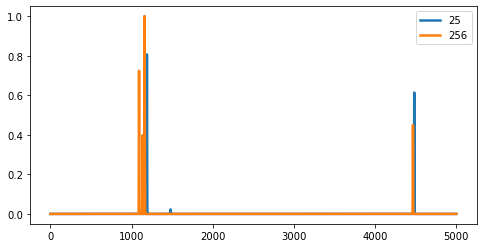

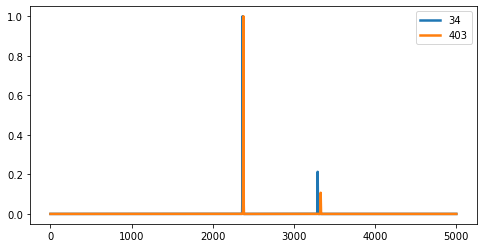

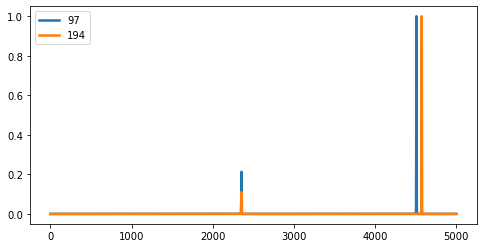

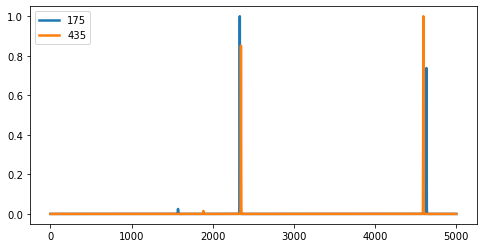

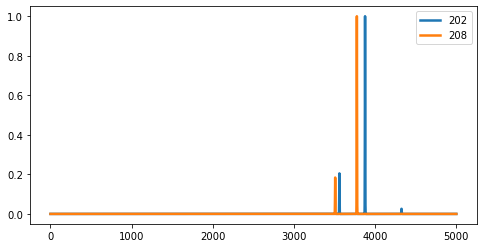

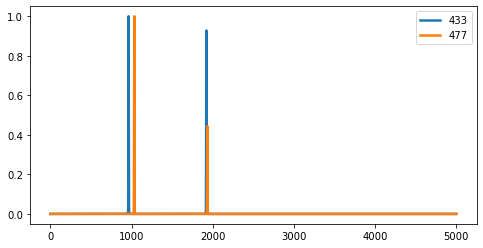

In [37]:
miscl = np.array([])
for i, p in enumerate(preds):
    if i == 0:
        miscl = np.unique(get_misclassification_pairs(p, ye), axis=0)
    else:
        miscl = np.vstack([miscl, np.unique(get_misclassification_pairs(p, ye), axis=0)])
miscl = np.unique(miscl, axis=0)

for miscl_idx in range(miscl.shape[0]):
    miscl1,miscl2 = miscl[miscl_idx]
    plt.figure(figsize=(8,4))
    plt.plot(xp[miscl1], lw=2.5, label=str(miscl1))
    plt.plot(xp[miscl2], lw=2.5, label=str(miscl2))
    plt.legend()
    plt.show()

#### CASE 1: Miss minor peaks

Classes 202 v 208

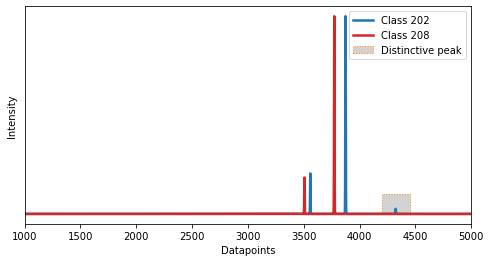

In [161]:
plt.figure(figsize=(8,4))
plt.fill([4200, 4200, 4450, 4450], [0., .1, .1, 0.], facecolor='lightgrey', 
         edgecolor='C1', ls='dotted', label='Distinctive peak')
plt.plot(xp[202], lw=2.5, label='Class 202', c='C0')
plt.plot(xp[208], lw=2.5, label='Class 208', c='C3')
h, l = plt.gca().get_legend_handles_labels()
h.append(h.pop(0))
l.append(l.pop(0))
plt.legend(h,l)
plt.xlabel('Datapoints')
plt.ylabel('Intensity')
plt.xlim(1000,5000)
plt.yticks([])
plt.savefig('results/Minor_Peak.png', dpi=300, bbox_inches='tight')
plt.show()

### CASE 2: Overlapping peak positions

In [71]:
print(config["spectra"]["175"])
print(config["spectra"]["435"])

{'peak_positions': [1571, 2332, 4631], 'peak_heights': [0.025, 1.0, 0.738]}
{'peak_positions': [1883, 2346, 4593], 'peak_heights': [0.015, 0.851, 1.0]}


In [78]:
from matplotlib.gridspec import GridSpec

cl1 = 97
cl2 = 194

train_pos = np.argmax(xt[:,2200:2500], axis=1) +2200
train_hi = np.max(xt[:,2200:2500], axis=1)
val_pos = np.argmax(xv[:,2200:2500], axis=1) +2200
val_hi = np.max(xv[:,2200:2500], axis=1)
test_pos = np.argmax(xtest[:,2200:2500], axis=1) +2200
test_hi = np.max(xtest[:,2200:2500], axis=1)

df = pd.DataFrame()
df['pos'] = np.hstack([train_pos[cl1*50:(cl1+1)*50],train_pos[cl2*50:(cl2+1)*50]])
df['hi'] = np.hstack([train_hi[cl1*50:(cl1+1)*50],train_hi[cl2*50:(cl2+1)*50]])
df['cl'] = np.repeat(np.array([0,1]), 50)

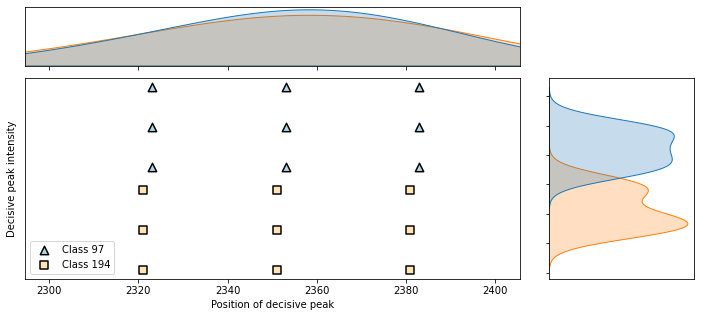

In [79]:
fig = plt.figure(figsize=(12,5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(test_pos[cl1*9:(cl1+1)*9],test_hi[cl1*9:(cl1+1)*9], s=70, 
            edgecolors='black', marker='^', lw=1.5, c='lightblue', label='Class 97')
ax_joint.scatter(test_pos[cl2*9:(cl2+1)*9],test_hi[cl2*9:(cl2+1)*9], s=70, 
            edgecolors='black', marker='s', lw=1.5, c='moccasin', label='Class 194')
#ax_joint.scatter(train_pos[cl1*50:(cl1+1)*50],train_hi[cl1*50:(cl1+1)*50])
#ax_joint.scatter(train_pos[cl2*50:(cl2+1)*50],train_hi[cl2*50:(cl2+1)*50])
sns.kdeplot(data=df, x='pos', hue='cl', ax=ax_marg_x, fill=True, bw_adjust=2.)
sns.kdeplot(data=df, y='hi', hue='cl', ax=ax_marg_y, fill=True, bw_adjust=1.2)
# remove labels + legend
ax_marg_x.set_xlabel('')
ax_marg_x.get_legend().remove()
ax_marg_x.set_yticks([])
ax_marg_y.set_ylabel('')
ax_marg_y.get_legend().remove()
ax_marg_y.set_xticks([])
# match lims of train and test data
xlim = ax_marg_x.get_xlim()
xlim = (xlim[0]+80,xlim[1]-80)
ax_marg_x.set_xlim(xlim)
#ylim = ax_marg_y.get_ylim()
# ylim = (0.77,0.95)
# ax_marg_y.set_ylim(ylim)
ax_joint.set_xlim(xlim)
# ax_joint.set_ylim(ylim)

ax_joint.set_yticks([])
ax_joint.legend(loc=3)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Position of decisive peak')
ax_joint.set_ylabel('Decisive peak intensity')

# Set labels on marginals
ax_marg_y.set_xlabel('')#('Train intensity')
ax_marg_x.set_ylabel('')#('Train pos.')
plt.savefig('results/position_overlap.png', dpi=500, bbox_inches='tight')
plt.show()